In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pip install finance-datareader

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
from scipy.optimize import minimize
from scipy import stats
plt.style.use("bmh")

# Technical Analysis library
import FinanceDataReader as fdr

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.utils import shuffle
from keras.regularizers import l2
from tensorflow.python.keras.models import load_model

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline

In [3]:
def get_environment():
    try:
        # Check if the environment is Google Colab
        import google.colab
        return "colab"
    except ImportError:
        # Environment is not Google Colab, assume it is local
        return "local"

environment = get_environment()

if environment == "colab":
    colab_path = "/content/drive/MyDrive/Colab Notebooks/"
elif environment == "local":
    colab_path = ""


df = pd.read_csv(colab_path + "top50-Stock_LogReturn.csv", index_col="Date")
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_len = len(train)
test_len = len(test)
validation_set_len = 80
validation_set_split_point = 60

xc_train = np.empty((train_len - validation_set_len, 60, 50))
xf_train = np.empty((train_len - validation_set_len, 20, 50))
xc_test = np.empty((test_len - validation_set_len, 60, 50))
xf_test = np.empty((test_len - validation_set_len, 20, 50))

for idx in range(train_len - validation_set_len):
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len):
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test

In [4]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
REG_CONST = 0.1

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# MPN에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)

def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

input_shape = xc_train.shape[1:]

model = build_model(
    input_shape,
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(custom_objects={'markowitz_objective': markowitz_objective}, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [6]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = tf.keras.Input(batch_shape = (None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.5, kernel_regularizer=l2(0.005))(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)  # linear projection

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다. 
# (over confidence 방지용). REG_CONST를 적용했기 때문에 이미 고려된 사항이지만, 
# 안전을 위해 추가했다. ex : [-3, 0.4, 0.2, +20] --> [-0.995, 0.380, 0.197, 1.0]|

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)
model = tf.keras.Model(xc_input, y_output)

In [7]:

# # MPN을 학습하고 결과를 저장한다.
SAVE_MODEL = 'Markowitz_network_prophet_CV'
ealry_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 1e-5))
hist = model.fit(xc_train, xf_train, epochs=500, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping])
model.save(SAVE_MODEL + '.h5')

Epoch 1/500
163/163 [==============================] - 8s 11ms/step - loss: 0.4034 - val_loss: 0.3983
Epoch 2/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3894 - val_loss: 0.3845
Epoch 3/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3758 - val_loss: 0.3712
Epoch 4/500
163/163 [==============================] - 1s 8ms/step - loss: 0.3627 - val_loss: 0.3582
Epoch 5/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3499 - val_loss: 0.3457
Epoch 6/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3376 - val_loss: 0.3336
Epoch 7/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3256 - val_loss: 0.3218
Epoch 8/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3140 - val_loss: 0.3103
Epoch 9/500
163/163 [==============================] - 1s 7ms/step - loss: 0.3027 - val_loss: 0.2992
Epoch 10/500
163/163 [==============================] - 1s 7ms/step - loss: 0.2918 - val_l

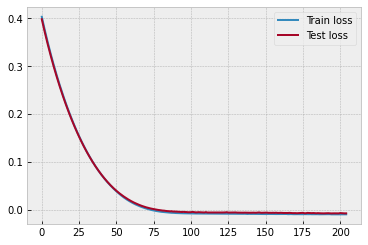

In [8]:
# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 373ms/step


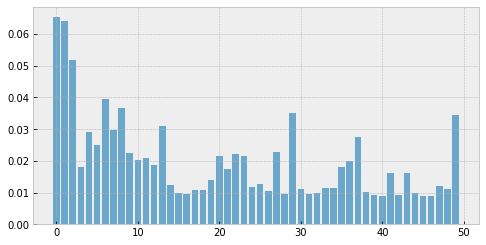

In [9]:
# 최적 포트폴리오 결과 조회용 코드

def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [34]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return portfolio_std

def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

def calc_portfolio_VaR(weights, mean_returns, cov, alpha):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def portfolio_optimization_std(w, r, cov):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_std, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_sharpe(w, r, cov, rf):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, rf)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_neg_sharpe, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_Var(w, r, cov, alpha):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, alpha)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_VaR, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

In [16]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = '/content/Markowitz_network_prophet_CV.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000]
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][-993:][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value,'S&P500':us500_value}, index=test[-993:].index[idx])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


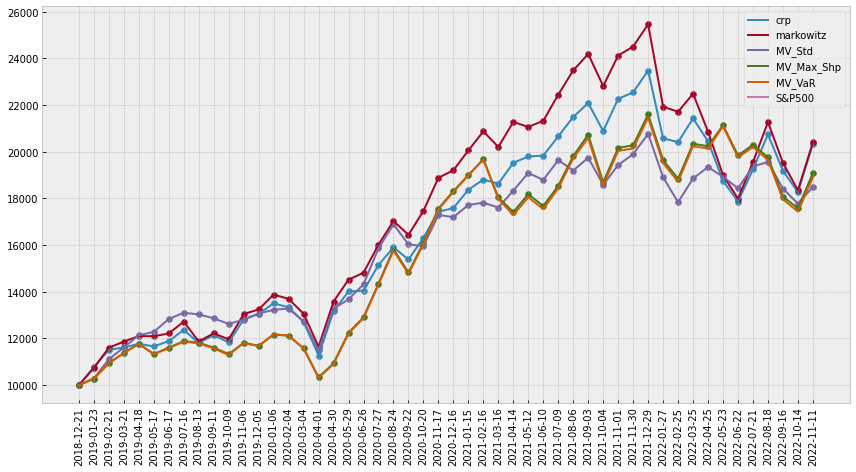

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(perf_df)
plt.tight_layout()
plt.scatter(perf_df.index, perf_df['crp'])
plt.scatter(perf_df.index, perf_df['markowitz'])
plt.scatter(perf_df.index, perf_df['MV_Std'])
plt.scatter(perf_df.index, perf_df['MV_Max_Shp'])
plt.scatter(perf_df.index, perf_df['S&P500'])
plt.xticks(perf_df.index, rotation=90)
plt.legend(perf_df)

<BarContainer object of 6 artists>

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45944 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text

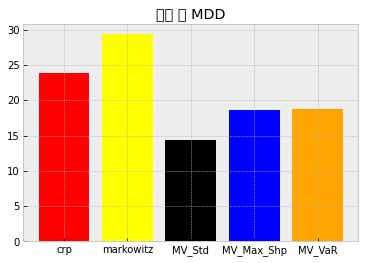

In [18]:
perf_df_mdd = perf_df.copy()
def mdd(df):
    return (df.cummax() - df) / df.cummax() * 100

temp_list = perf_df_mdd.columns
for i in temp_list:
    perf_df_mdd[i] = mdd(perf_df_mdd[i])
    
c = ['red', 'yellow', 'black', 'blue', 'orange', 'green']
plt.title('모델 별 MDD')
plt.bar(perf_df_mdd.columns, height=perf_df_mdd.max(), color=c)

crp           0.178956
markowitz     0.190868
MV_Std        0.145209
MV_Max_Shp    0.187630
MV_VaR        0.186113
S&P500             NaN
dtype: float64


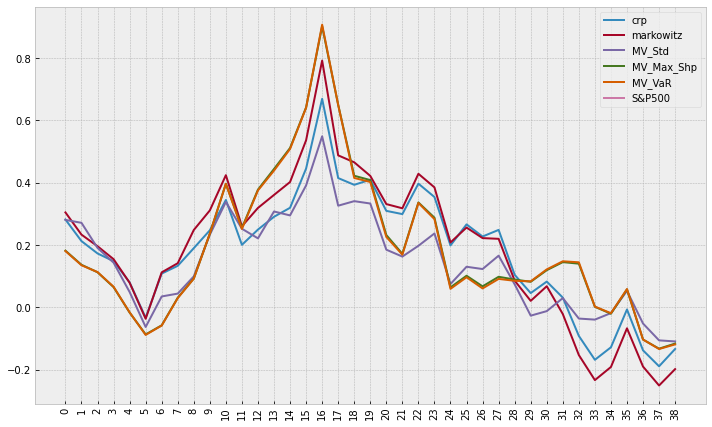

In [19]:
anual_perf = []

for i in range(len(perf_df) - 11):
    anual_perf.append(((perf_df.iloc[i+11] - perf_df.iloc[i]) / perf_df.iloc[i]))

anual_perf_df = pd.DataFrame(anual_perf)
plt.figure(figsize=(10, 6))
plt.plot(anual_perf_df)
plt.tight_layout()
#plt.scatter(perf_df.index, perf_df['crp'])
#plt.scatter(perf_df.index, perf_df['markowitz'])
#plt.scatter(perf_df.index, perf_df['S&P500'])
plt.xticks(anual_perf_df.index, rotation=90)
plt.legend(anual_perf_df)
print(anual_perf_df.mean())

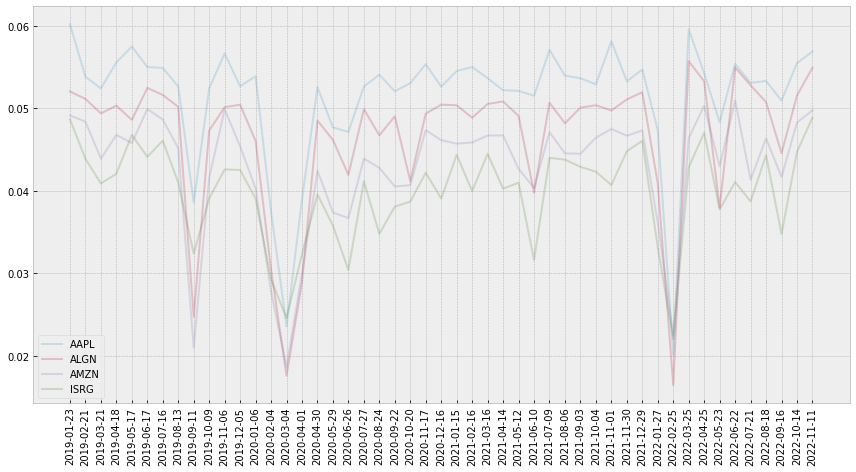

In [20]:
w_ratio = pd.DataFrame(w_history, columns=test.columns, index=perf_df.index[1:])
w_ratio = w_ratio[w_ratio.sum().sort_values(ascending=False).index]
plt.figure(figsize=(12, 6))
plt.plot(w_ratio.iloc[:, :4], alpha=0.2)
plt.tight_layout()
plt.xticks(w_ratio.index, rotation=90)
plt.legend(w_ratio.columns)

In [35]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_prophet_CV.h5'
model = load_model(SAVE_MODEL, compile = True, custom_objects={'markowitz_objective': markowitz_objective})
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000]
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

    # 추가로 발생한 시장 데이터로 MPN을 추가 학습시킨다.
    # xc_test[0] ~ xc_test[19],
    # xf_test[0] ~ xf_test[19]를 추가로 학습시킬 수 있다.
    xc_new = xc_test[i:(i+N_FUTURE), :, :]
    xf_new = xf_test[i:(i+N_FUTURE), :, :]

    # xc_train 데이터에서 80개를 random sampling 한다.
    idx = np.random.randint(0, xc_train.shape[0], 80)

    # 추가 학습 데이터를 생성한다.
    x = np.vstack([xc_new, xc_train[idx]])
    y = np.vstack([xf_new, xf_train[idx]])
    x, y = shuffle(x, y)

    # 추가 학습한다.
    model.fit(x, y, epochs=50, batch_size=10, verbose=0)

    # 추가로 발생한 데이터도 이후에 sampling될 수 있도록 보관해 둔다.
    xc_train = np.vstack([xc_train, xc_new])
    xf_train = np.vstack([xf_train, xf_new])

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][-993:][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value,'S&P500':us500_value}, index=test[-993:].index[idx])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 